In [0]:
#import os
#import zipfile
#if not os.path.exists('./apple2orange'):
#    if os.path.exists('../input/apple2orange.zip'):
#        with zipfile.ZipFile('/content/apple2orange.zip', 'r') as zip_obj:
#            zip_obj.extractall('./')
#    else:
#        !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
#        with zipfile.ZipFile('/content/apple2orange.zip', 'r') as zip_obj:
#            zip_obj.extractall('./')

# Реализация CycleGAN 
Цель обучения - превратить портреты лягушек в портреты людей. За датасет лягушек спасибо Ольги Вишневской и паблику в вк Пепеланджело

In [0]:
import os
import zipfile
with zipfile.ZipFile('/content/face2peepo.zip', 'r') as zip_obj:
  zip_obj.extractall('./')

In [2]:
import torch
import os
import torch.nn.functional as F
import numpy as np
from torch import nn
import itertools
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.figure(figsize=(18, 6))

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [0]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [0]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self):
    super().__init__()
    self.transforms  = transforms.Compose([
                transforms.Resize(int(256*1.12)), 
                transforms.RandomCrop(256), 
                transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ]
    )
    self.files_A = sorted(os.path.join('/content/face2peepo/TrainA', i) for i in os.listdir('/content/face2peepo/TrainA'))
    self.files_B = sorted(os.path.join('/content/face2peepo/TrainB', i) for i in os.listdir('/content/face2peepo/TrainB'))
    self.files_A = list(filter(lambda x: Image.open(x).layers==3, self.files_A))
    self.files_B = list(filter(lambda x: Image.open(x).layers==3, self.files_B))
    
  def __getitem__(self,index):
    item_A = self.transforms(Image.open(self.files_A[index % len(self.files_A)]))
    item_B = self.transforms(Image.open(self.files_B[index % len(self.files_B)]))
    return item_A, item_B

  def __len__(self):
    return max(len(self.files_A), len(self.files_B))

In [0]:
def train():
  true_ = torch.Tensor([[1]]).cuda()
  false_ = torch.Tensor([[0]]).cuda()
  for epoch in range(num_epoch):
    pbar = tqdm(total=len(data_loader))
    for A,B in data_loader:
      if A.shape[1]==1 or B.shape[1]==1:
        continue
      losses_G_B2A_batch = []
      losses_G_A2B_batch = []
      losses_cycle_A_batch = []
      losses_cycle_B_batch = []
      losses_D_A_batch = []
      losses_D_B_batch = []

      A = A.to(DEVICE)
      B = B.to(DEVICE)
      optimizer_G.zero_grad()

      #true_ = torch.Tensor([[1]]).cuda()
      #false_ = torch.Tensor([[0]]).cuda()
      
      same_A = netG_B2A(A)
      same_B = netG_A2B(B)
      loss_identity_B = loss_identity(same_B, B)*5.0
      loss_identity_A = loss_identity(same_A, A)*5.0
      fake_A = netG_B2A(B)
      fake_B = netG_A2B(A)
      pred_fake_A = netD_A(fake_A)
      pred_fake_B = netD_B(fake_B)
      
      Loss_GAN_B2A = loss_GAN(pred_fake_A, false_)
      Loss_GAN_A2B = loss_GAN(pred_fake_B, false_)
      losses_G_A2B_batch.append(Loss_GAN_A2B.item())
      losses_G_B2A_batch.append(Loss_GAN_B2A.item())

      recovered_A = netG_B2A(fake_B)
      recovered_B = netG_A2B(fake_A)

      Loss_cycle_A = loss_cycle(recovered_A,A)*10.0
      Loss_cycle_B = loss_cycle(recovered_B,B)*10.0
      
      losses_cycle_A_batch.append(Loss_cycle_A.item())
      losses_cycle_B_batch.append(Loss_cycle_B.item())

      Full_loss = Loss_GAN_B2A + Loss_GAN_A2B + Loss_cycle_A + Loss_cycle_B + loss_identity_B +loss_identity_A
      Full_loss.backward()
      optimizer_G.step()


      #opt D_A
      optimizer_D_A.zero_grad()
      pred_real_A = netD_A(A)
      real_loss_A = loss_GAN(pred_real_A, true_)
      pred_fake_A = netD_A(fake_A.detach())
      fake_loss_A = loss_GAN(pred_fake_A, false_)
      D_A_loss = (fake_loss_A +fake_loss_A)*0.5
      D_A_loss.backward()
      optimizer_D_A.step()
      losses_D_A_batch.append(D_A_loss.item())

      #opt D_B
      optimizer_D_B.zero_grad()
      pred_real_B = netD_B(B)
      real_loss_B = loss_GAN(pred_real_B, true_)
      pred_fake_B = netD_B(fake_B.detach())
      fake_loss_B = loss_GAN(pred_fake_B, false_)
      D_B_loss = (fake_loss_B +fake_loss_B)*0.5
      D_B_loss.backward()
      optimizer_D_B.step()
      losses_D_B_batch.append(D_B_loss.item())
      pbar.update(1)
      pbar.set_description("Epoch: {}".format(epoch))
    
    plt.figure(figsize=(24, 24));
    clear_output(wait=True);
    img_a, img_b = dataset[epoch]
    plt.subplot(2, 6, 1);
    plt.imshow(img_a.permute(2,1,0)*0.5+0.5);
    plt.title('Real_A');
    plt.axis('off');
    
    plt.subplot(2, 6, 2);
    fake_b = netG_A2B(img_a.unsqueeze(0).cuda()).cpu().detach()*0.5+0.5
    plt.imshow(fake_b.squeeze().permute(2,1,0));
    plt.title('A2B');
    plt.axis('off');
    plt.subplot(2, 6, 3);
    plt.imshow(img_b.permute(2,1,0)*0.5+0.5);
    plt.title('Real_B');
    plt.axis('off');
    plt.subplot(2, 6, 4);
    fake_a = netG_B2A(img_b.unsqueeze(0).cuda()).cpu().detach()*0.5+0.5
    plt.imshow(fake_a.squeeze().permute(2,1,0));
    plt.title('B2A');
    plt.axis('off');
    plt.show();
    


    losses_D_A.append(np.mean(losses_G_B2A_batch))
    losses_D_B.append(np.mean(losses_G_A2B_batch))
    losses_G_A2B.append(np.mean(losses_cycle_A_batch))
    losses_G_B2A.append(np.mean(losses_cycle_B_batch))
    losses_cycle_A.append(np.mean(losses_D_A_batch))
    losses_cycle_B.append(np.mean(losses_D_B_batch))
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    pbar.close()
     


In [0]:
dataset = Dataset()

In [0]:
netG_A2B = Generator(3,3,6)
netG_B2A = Generator(3,3,6)
netD_A = Discriminator(3)
netD_B = Discriminator(3)

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [51]:
DEVICE

device(type='cuda')

In [0]:
data_loader = DataLoader(dataset)

In [0]:
netG_A2B.to(DEVICE);
netG_B2A.to(DEVICE);
netD_A.to(DEVICE);
netD_B.to(DEVICE);

In [0]:
loss_GAN = nn.MSELoss()
loss_cycle = nn.L1Loss()
loss_identity = nn.L1Loss() 

In [0]:
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(),netG_B2A.parameters()),lr=0.002)
optimizer_D_A = torch.optim.Adam(netD_A.parameters())
optimizer_D_B = torch.optim.Adam(netD_B.parameters())

In [0]:
num_epoch = 71

In [0]:
lr_scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, 40)
lr_scheduler_D_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, 40)
lr_scheduler_D_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, 40)

In [0]:
losses_D_A = []
losses_D_B = []
losses_G_A2B = []
losses_G_B2A = []
losses_cycle_A = []
losses_cycle_B = []

In [0]:
def save_weights():
  torch.save(netG_A2B.state_dict(),'NetG_A2B_71epoch')
  torch.save(netG_B2A.state_dict(),'NetG_B2A_71epoch')
  torch.save(netD_A.state_dict(),'D_A_71epoch')
  torch.save(netD_B.state_dict(),'D_B_71epoch')

In [0]:
train()

In [0]:
save_weights()

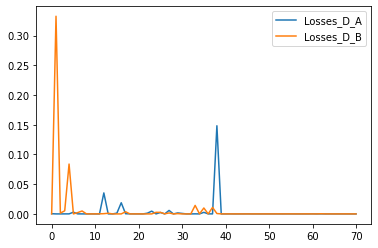

In [146]:
plt.plot(losses_D_A, label='Losses_D_A')
plt.plot(losses_D_B,label='Losses_D_B')
plt.legend()

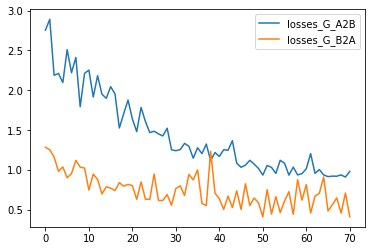

In [147]:
plt.plot(losses_G_A2B,label='losses_G_A2B')
plt.plot(losses_G_B2A,label='losses_G_B2A')
plt.legend()

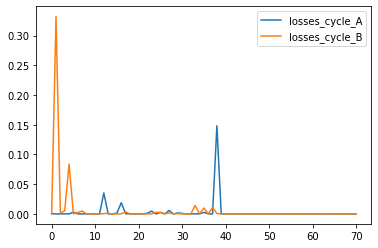

In [148]:
plt.plot(losses_cycle_A,label='losses_cycle_A')
plt.plot(losses_cycle_B,label='losses_cycle_B')
plt.legend()

# Результаты. 
Один из генераторов научился менять цвет кожи лягушки на цвет кожи человека, получилось не плохо.
Второй генератор меняет меняет оттенок кожи на зелёный (это было ожидаемо но не так интересно) продемонстрирую работу первого генератора


In [0]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self):
    super().__init__()
    self.transforms  = transforms.Compose([
                transforms.Resize(256), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
    )
    self.files_A = sorted(os.path.join('/content/face2peepo/TrainA', i) for i in os.listdir('/content/face2peepo/TrainA'))
    self.files_B = sorted(os.path.join('/content/face2peepo/TrainB', i) for i in os.listdir('/content/face2peepo/TrainB'))
    self.files_A = list(filter(lambda x: Image.open(x).layers==3, self.files_A))
    self.files_B = list(filter(lambda x: Image.open(x).layers==3,self.files_B))
    
  def __getitem__(self,index):
    item_A = self.transforms(Image.open(self.files_A[index % len(self.files_A)]))
    item_B = self.transforms(Image.open(self.files_B[index % len(self.files_B)]))
    return item_A, item_B

  def __len__(self):
    return max(len(self.files_A), len(self.files_B))

In [0]:
data = TestDataset()
A1, B = data[10]
A2, B = data[3]
A3, B = data[4]
A4, B = data[44]

(-0.5, 255.5, 343.5, -0.5)

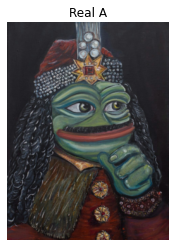

In [128]:
plt.imshow(A1.permute(1,2,0)*0.5+0.5)
plt.title('Real A')
plt.axis('off')

(-0.5, 255.5, 343.5, -0.5)

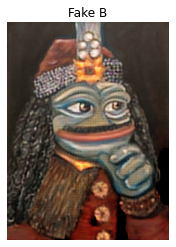

In [129]:
fake_B = netG_A2B(A1.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_B.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake B')
plt.axis('off')

(-0.5, 255.5, 319.5, -0.5)

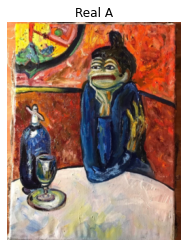

In [130]:
plt.imshow(A2.permute(1,2,0)*0.5+0.5)
plt.title('Real A')
plt.axis('off')

(-0.5, 255.5, 319.5, -0.5)

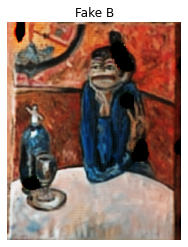

In [131]:
fake_B = netG_A2B(A2.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_B.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake B')
plt.axis('off')

(-0.5, 255.5, 341.5, -0.5)

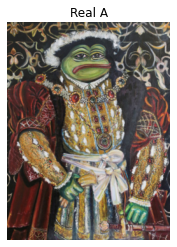

In [132]:
plt.imshow(A3.permute(1,2,0)*0.5+0.5)
plt.title('Real A')
plt.axis('off')

(-0.5, 255.5, 343.5, -0.5)

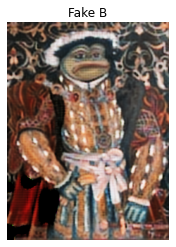

In [133]:
fake_B = netG_A2B(A3.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_B.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake B')
plt.axis('off')

(-0.5, 255.5, 340.5, -0.5)

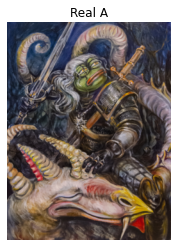

In [134]:
plt.imshow(A4.permute(1,2,0)*0.5+0.5)
plt.title('Real A')
plt.axis('off')

(-0.5, 255.5, 343.5, -0.5)

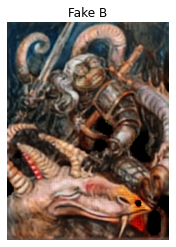

In [135]:
fake_B = netG_A2B(A4.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_B.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake B')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

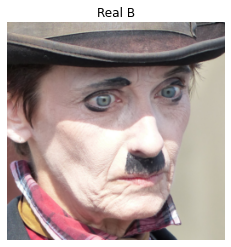

In [136]:
plt.imshow(B.permute(1,2,0)*0.5+0.5)
plt.title('Real B')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

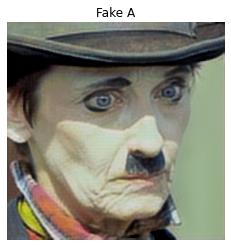

In [137]:
fake_A = netG_B2A(B.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_A.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake A')
plt.axis('off')

In [0]:
assert StopIteration

# Проверка модели и цила обучения на стандартных данных
epoch = 14
n_blocks = 6

(-0.5, 255.5, 255.5, -0.5)

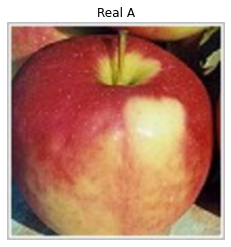

In [0]:
plt.imshow(A.permute(1,2,0)*0.5+0.5)
plt.title('Real A')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

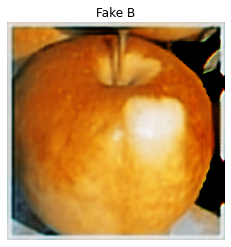

In [0]:
fake_B = netG_A2B(A.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_B.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake B')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

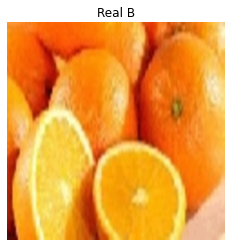

In [0]:
plt.imshow(B.permute(1,2,0)*0.5+0.5)
plt.title('Real B')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

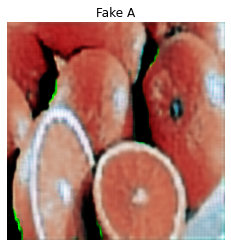

In [0]:
fake_A = netG_B2A(B.unsqueeze(0).cuda())*0.5+0.5
plt.imshow(fake_A.squeeze().permute(1,2,0).cpu().detach())
plt.title('Fake A')
plt.axis('off')

Видно что всё работает как и планировалось